In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os, argparse, math, random
from datetime import datetime
import errno
import sklearn.svm as svm 

start_time = datetime.now()

outputPath = "../../output/svm/1b/"

if not os.path.exists(os.path.dirname(outputPath)):
    try:
        os.makedirs(os.path.dirname(outputPath))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

inputPath = "../../dataset/data_set2/"

train = ["class1.txt", "class2.txt", "class3.txt"]
test = ["classt1.txt", "classt2.txt", "classt3.txt"]

In [18]:
testData = []
trainData = []


def fileHandle(fileName):
    print("Reading: ", fileName)
    wholeData = []
    file = open(fileName)
    for line in file:
        teLine = line.rstrip('\n ').split(' ')
        nLine = [float(i) for i in teLine]
        nLine = np.array(nLine)
#         nLine = np.insert(nLine, 0, 1, axis=0)
        wholeData.append(nLine)
    file.close()
    wholeData = np.array(wholeData)
#     print(wholeData)
    return wholeData

count = 0

for filename in train:
    val = fileHandle(inputPath + filename)
    print(val.shape)
    trainData.append(val)
    
for filename in test:
    val = fileHandle(inputPath + filename)
    testData.append(val)

testData = np.array(testData)
trainData = np.array(trainData)

print(testData.shape)
print(trainData.shape)

Reading:  ../../dataset/data_set2/class1.txt
(375, 2)
Reading:  ../../dataset/data_set2/class2.txt
(375, 2)
Reading:  ../../dataset/data_set2/class3.txt
(750, 2)
Reading:  ../../dataset/data_set2/classt1.txt
Reading:  ../../dataset/data_set2/classt2.txt
Reading:  ../../dataset/data_set2/classt3.txt
(3,)
(3,)


In [29]:
def plot(mainList, obj, name):
#     mainList = trainDataOrig
    numFeature = 2
    nClass = 3
    
    
    minMax = np.zeros((numFeature,2))
    colors = ['#136906', '#fcbdfc', '#e5ff00', '#ff0000', '#3700ff', '#000000']

    # Resolution affects the time required to process.
    res = 200

    count = 0
    for i in range(nClass):
        for j in range(numFeature):
            if count == 0:
                minMax[j, 0] = np.ceil(np.amin(mainList[i][:, j]))
                minMax[j, 1] = np.ceil(np.amax(mainList[i][:, j]))
            else:
                minMax[j, 0] = min(minMax[j,0], np.ceil(np.amin(mainList[i][:, j])))
                minMax[j, 1] = max(minMax[j,1], np.ceil(np.amax(mainList[i][:, j])))
            count = 1

    dataRange = np.zeros((numFeature))
    for i in range(numFeature):
        dataRange[i] = 0.1*(minMax[i, 1] - minMax[i, 0])

    x = np.linspace(minMax[0, 0] - dataRange[0], minMax[0, 1] + dataRange[0], res)
    y = np.linspace(minMax[1,0] - dataRange[1], minMax[1,1] + dataRange[1], res)

    tellClassNum = []#np.zeros((np.size(x,0)*np.size(y,0), nClass))

    count = 0
    points = []
    for j in y:
        for i in x:
            dataPt = np.array([i, j])
            points.append(dataPt)
            
    decisions = obj.predict(points)

    for idx in range(1):
        fig1 = plt.figure(1)
        ax = fig1.gca()

        plotClass = []
        for cl in range(nClass):
            temp1 = []
            for fe in range(numFeature):
                temp1.append([])
            plotClass.append(temp1)

        class_colours = []
        classes = []
        count = 0
        for j in y:
            for i in x:
                classNum = decisions[count]
                plotClass[int(classNum)][0].append(i)
                plotClass[int(classNum)][1].append(j)
                count += 1

        plotname = name + ".png"
        
        ax.plot(plotClass[0][0], plotClass[0][1], c = colors[0],marker=".",  linestyle="None", label="Class 1 Prediction")
        ax.plot(plotClass[1][0], plotClass[1][1], c = colors[1],marker=".",  linestyle="None", label="Class 2 Prediction")
        ax.plot(plotClass[2][0], plotClass[2][1], c=colors[2],marker=".",  linestyle="None", label="Class 3 Prediction")
        ax.plot(mainList[0][:,0],mainList[0][:,1], c = colors[3], marker=".",  linestyle="None", label="Class 1 Data", ms='2')
        ax.plot(mainList[1][:,0],mainList[1][:,1], c = colors[4], marker=".",  linestyle="None", label="Class 2 Data", ms='2')
        ax.plot(mainList[2][:,0],mainList[2][:,1], c = colors[5], marker=".",  linestyle="None", label="Class 3 Data", ms='2')
        class_colours = [colors[3], colors[4], colors[5], colors[0], colors[1], colors[2]]
        classes = ["Class 1 Data", "Class 2 Data", "Class 3 Data", "Class 1 Prediction", "Class 2 Prediction", "Class 3 Prediction"]
        plotname = "123" + plotname
            
        ax.patch.set_visible(False)
        plt.title("Class 1 - Class 2 - Class 3")
        plotname = outputPath + plotname
        plt.xlabel('X')
        plt.ylabel('Y')
        recs = []
        for i in range(0,len(class_colours)):
            recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
        plt.legend(recs, classes, loc='upper right')
        plt.savefig(plotname)
        print(plotname)
#         plt.show()
    
def ana(confusionMatrix):
    precision = []
    for i in range(3):
        s = 0
        for j in range(3):
            s += confusionMatrix[i][j]
        p = confusionMatrix[i][i]/s
        precision.append(p)

    recall = []
    for i in range(3):
        s = 0
        for j in range(3):
            s += confusionMatrix[j][i]
        r = confusionMatrix[i][i]/s
        recall.append(r)

    fMeasure = []

    for i in range(3):
        fMeasure.append((2*precision[i]*recall[i])/(precision[i]+recall[i]))

    s = 0
    correct = 0
    for i in range(3):
        correct += confusionMatrix[i][i]
        for j in range(3):
            s += confusionMatrix[i][j]
    accuracy = correct/s

    print("precision: \t",precision)
    print("recall: \t", recall)
    print("F Measure: \t", fMeasure)
    print("Accuracy: ", accuracy)
    
    print("Average precision: ", (precision[0]+precision[1]+precision[2])/3)
    print("Average recall: ", (recall[0]+recall[1]+recall[2])/3)
    print("Average fMeasure: ", (fMeasure[0]+fMeasure[1]+fMeasure[2])/3)
    

In [30]:
mainList = trainData
nClass = 3

X=mainList[0]
for i in range(1,nClass):
    X=np.concatenate((X,mainList[i]),axis=0)
# print(X.shape)
Y=np.zeros(len(mainList[0]),int)
for i in range(1,nClass):
    b=(np.zeros(len(mainList[i]),int)+i)
    Y=np.concatenate((Y,b))

[[  0   0 125]
 [  0   0 125]
 [  0   0 250]]
../../output/svm/1b/123_1a_svm_linear.png
precision: 	 [0.0, 0.0, 1.0]
recall: 	 [nan, nan, 0.5]
F Measure: 	 [nan, nan, 0.6666666666666666]
Accuracy:  0.5
Average precision:  0.3333333333333333
Average recall:  nan
Average fMeasure:  nan


c:\python37\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in long_scalars


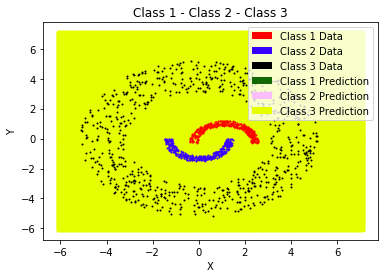

In [31]:
clf = svm.SVC(kernel='linear')
clf.fit(X,Y)
# a=np.array([[1,1.2],[2,4]],float)
confusionMatrix = np.zeros((nClass,nClass),int)

for i in range(nClass):
    pr=clf.predict(testData[i])
    for j in pr:
        confusionMatrix[i][j]+=1

print(confusionMatrix)

plot(trainData, clf, "_1a_svm_linear")

ana(confusionMatrix)

[[116   9   0]
 [  9 116   0]
 [  0   0 250]]
../../output/svm/1b/123_1a_svm_poly_2.png
precision: 	 [0.928, 0.928, 1.0]
recall: 	 [0.928, 0.928, 1.0]
F Measure: 	 [0.928, 0.928, 1.0]
Accuracy:  0.964
Average precision:  0.952
Average recall:  0.952
Average fMeasure:  0.952


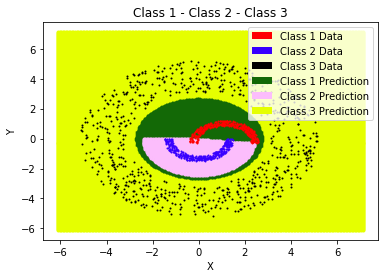

In [35]:
clf2 = svm.SVC(kernel='poly',gamma='auto',coef0=2,degree=2)
clf2.fit(X,Y)
# a=np.array([[1,1.2],[2,4]],float)
confusionMatrix = np.zeros((nClass,nClass),int)

for i in range(nClass):
    pr=clf2.predict(testData[i])
    for j in pr:
        confusionMatrix[i][j]+=1

print(confusionMatrix)

plot(trainData, clf2, "_1a_svm_poly_2")

ana(confusionMatrix)

[[125   0   0]
 [  0 125   0]
 [  0   0 250]]
../../output/svm/1b/123_1a_svm_poly_3.png
precision: 	 [1.0, 1.0, 1.0]
recall: 	 [1.0, 1.0, 1.0]
F Measure: 	 [1.0, 1.0, 1.0]
Accuracy:  1.0
Average precision:  1.0
Average recall:  1.0
Average fMeasure:  1.0


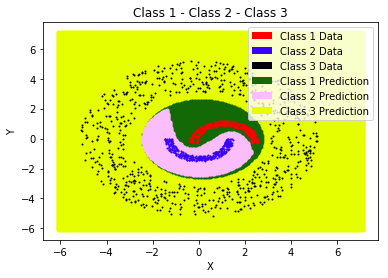

In [36]:
clf2 = svm.SVC(kernel='poly',gamma='auto',coef0=3,degree=3)
clf2.fit(X,Y)
# a=np.array([[1,1.2],[2,4]],float)
confusionMatrix = np.zeros((nClass,nClass),int)

for i in range(nClass):
    pr=clf2.predict(testData[i])
    for j in pr:
        confusionMatrix[i][j]+=1

print(confusionMatrix)

plot(trainData, clf2, "_1a_svm_poly_3")

ana(confusionMatrix)

[[125   0   0]
 [  0 125   0]
 [  0   0 250]]
../../output/svm/1b/123_1a_svm_rbf.png
precision: 	 [1.0, 1.0, 1.0]
recall: 	 [1.0, 1.0, 1.0]
F Measure: 	 [1.0, 1.0, 1.0]
Accuracy:  1.0
Average precision:  1.0
Average recall:  1.0
Average fMeasure:  1.0


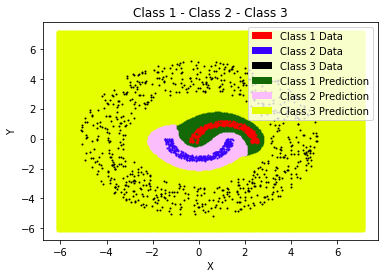

In [33]:
clf2 = svm.SVC(kernel='rbf',gamma='auto')
clf2.fit(X,Y)
# a=np.array([[1,1.2],[2,4]],float)
confusionMatrix = np.zeros((nClass,nClass),int)

for i in range(nClass):
    pr=clf2.predict(testData[i])
    for j in pr:
        confusionMatrix[i][j]+=1

print(confusionMatrix)

plot(trainData, clf2, "_1a_svm_rbf")

ana(confusionMatrix)